# Identificación de sistemas
El objetivo de esta actividad es obtener el mejor modelo posible a partir de los datos medidos en forma experimental. 

Se propone:

1.  En principio ajusta la curva de un modelo de primer orden mas retardo (FOPDT en ingles)
2.  Ajustar a un modelo de segundo orden mas retardo (SOPDT).
3.  Usar el paquete scipy para ajusta los parámetros minimizando la función objetivo (ver ejemplo)
4.  Probar https://pidtuner.com/ para obtener un modelo

Simular y comparando los resultados de los modelos con los datos experimentales saque y discuta las conclusiones, ¿Modificaría el experimento? ¿Qué datos haría falta?

## ejemplo optimización

Initial SSE Objective: 44.242421067706736
Final SSE Objective: 0.029303544131414345
Kp: 2.9875384486035004
taup: 1.5121315783526064
zeta: 0.8368525209128814
thetap: 2.0483868635605487


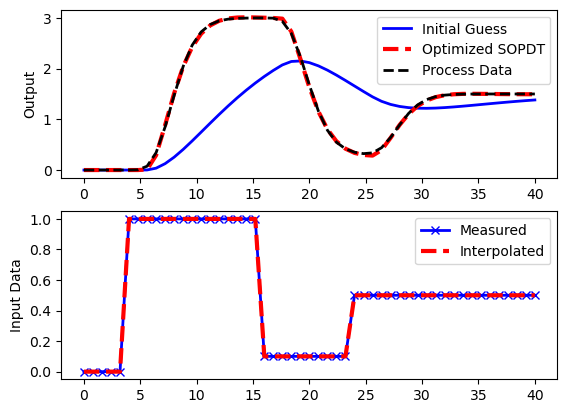

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import warnings

# Import CSV data file
# Column 1 = time (t)
# Column 2 = u (u)
# Column 3 = y (yp)
data = pd.read_csv(r'data_ejemplo.txt')
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
y0 = yp[0]
xp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

def sopdt(x,t,uf,Kp,taus,zeta,thetap):
    # Kp = process gain
    # taus = second order time constant
    # zeta = damping factor
    # thetap = model time delay
    # ts^2 dy2/dt2 + 2 zeta taus dydt + y = Kp u(t-thetap)
    # time-shift u
    try:
        if (t-thetap) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetap)
    except:
        # catch any error
        um = u0
    # two states (y and y')
    y = x[0] - y0
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*taus*dydt - y + Kp*(um-u0))/taus**2
    return [dydt,dy2dt2]

# simulate model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Kp = x[0]
    taus = x[1]
    zeta = x[2]
    thetap = x[3]
    # storage for model values
    xm = np.zeros((ns,2))  # model
    # initial condition
    xm[0] = xp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        inputs = (uf,Kp,taus,zeta,thetap)
        # turn off warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # integrate SOPDT model
            x = odeint(sopdt,xm[i],ts,args=inputs)
        xm[i+1] = x[-1]
    y = xm[:,0]
    return y

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
p0 = np.zeros(4)
p0[0] = 3 # Kp
p0[1] = 5.0 # taup
p0[2] = 1.0 # zeta
p0[3] = 2.0 # thetap

# show initial objective
print('Initial SSE Objective: ' + str(objective(p0)))

# optimize Kp, taus, zeta, thetap
solution = minimize(objective,p0)

# with bounds on variables
#no_bnd = (-1.0e10, 1.0e10)
#low_bnd = (0.01, 1.0e10)
#bnds = (no_bnd, low_bnd, low_bnd, low_bnd)
#solution = minimize(objective,p0,method='SLSQP',bounds=bnds)

p = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(p)))

print('Kp: ' + str(p[0]))
print('taup: ' + str(p[1]))
print('zeta: ' + str(p[2]))
print('thetap: ' + str(p[3]))

# calculate model with updated parameters
ym1 = sim_model(p0)
ym2 = sim_model(p)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized SOPDT')
plt.plot(t,yp,'k--',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.savefig('results.png')
plt.show()